# Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

# Constants

In [2]:
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
SPAM_ICON = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
HAM_ICON = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

VOCAB_SIZE = 2500

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TESTING_DATA_FILE = 'SpamData/03_Testing/test-data.txt'

# Reading files

In [3]:
stream = open(EXAMPLE_FILE,encoding='latin-1')
message = stream.read()
stream.close()

In [4]:
print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
# Seeing the encoding on our systen 
import sys
print(sys.getfilesystemencoding())

utf-8


In [6]:
def get_email_body(path):
    with open(path) as f:  #open the example file
        #lines = f.readlines() #read all the lines and get the list of lines
        body_lines = [] #create an empty list of lines which will only contain the body lines
        is_body = False #initialize is_body to false as no email starts with a body
        for line in f: #loop through the lines
            if is_body: #if the line is in the body
                body_lines.append(line) #append the line to body_lines
            elif line == '\n': #if the line is a new line character (ie the body of email has started)
                is_body = True #set is_body to True
    email_body = '\n'.join(body_lines) #join all the lines with a \n character
    return email_body #print the email body

In [7]:
email_body = get_email_body(EXAMPLE_FILE)

# Generator functions

In [8]:
def generate_squares(N):
    for my_num in range(N):
        yield my_num**2

In [9]:
for i in generate_squares(5):
    print(i, end='-->')

0-->1-->4-->9-->16-->

In yield keyword, the function remembers where it left off and it does not waste time in calculating the squares of 0,1,2 again

# Email body Extraction

In [10]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body


In [11]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [12]:
spam_emails = df_from_directory(SPAM_1_PATH,1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))

In [13]:
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [14]:
spam_emails.shape

(1898, 2)

In [15]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

In [16]:
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [17]:
ham_emails.shape

(3901, 2)

In [18]:
data = pd.concat([spam_emails, ham_emails])
print(f'Shape of entire dataframe is {data.shape}')

Shape of entire dataframe is (5799, 2)


In [19]:
data.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [20]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning and Preprocessing

In [21]:
data['MESSAGE'].isnull().sum()

0

In [22]:
(data['MESSAGE'].str.len() == 0).sum() # 3 empty emails

3

In [23]:
drop_idx = data[data['MESSAGE'].str.len() == 0].index

In [24]:
drop_idx # shows that it is a cmds file (system file) and does not have anything to do with our emails

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove system files froom dataset 

In [25]:
data.drop(drop_idx, inplace=True)

In [26]:
data.shape #Entries have been dropped

(5796, 2)

# Add document ids to track emails in dataset

In [27]:
data['FILE_NAME'] = data.index

In [28]:
data.reset_index(drop=True,inplace=True)

In [29]:
data.head()

,MESSAGE,CATEGORY,FILE_NAME
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [30]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save the file 

In [31]:
data.to_json(DATA_JSON_FILE)

# Number of spam messages vizualized (pie charts)

In [32]:
data['CATEGORY'].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [33]:
amount_of_spam = data['CATEGORY'].value_counts()[1]
amount_of_ham = data['CATEGORY'].value_counts()[0]

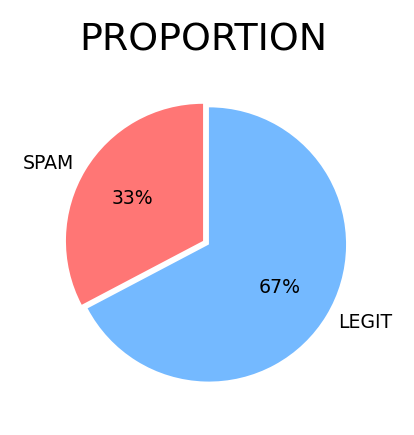

In [34]:
category_names = ['SPAM','LEGIT']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675','#74b9ff']
fig, ax = plt.subplots(figsize=(2,2),dpi=227)
ax.pie(sizes, labels=category_names,textprops={'fontsize':6},startangle=90,autopct='%1.0f%%',colors = custom_colors,explode=[0,0.05])
ax.set_title('PROPORTION')
plt.show()

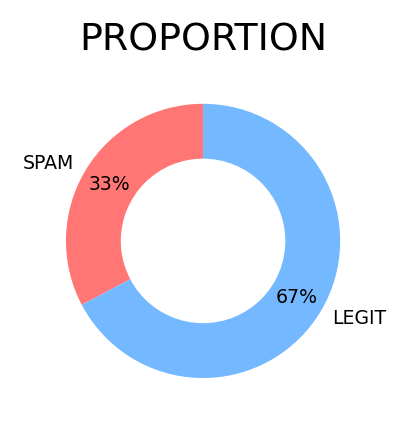

In [35]:
fig, ax = plt.subplots(figsize=(2,2),dpi=227)
ax.pie(sizes, labels=category_names,textprops={'fontsize':6},startangle=90,autopct='%1.0f%%',colors = custom_colors,pctdistance=0.8)

# sizes = the proportion of data labels to draw on pie chart 
# labels = the category names to display
# textprops = properties of text displayed on the pie chart 
# startngle = rotate the pie chart by x degrees
# autopct = precision of text displayed on pie chart
# colors = colors on the pie chart (if we do not like the default colors)
# pctdistance = keep the text towards outside

ax.set_title('PROPORTION')
#DRAW A CIRCLE 
center_circle = plt.Circle((0,0),radius=0.6,fc='white') #create a white circle to cover pie chart and make it look like donut chart
plt.gca().add_artist(center_circle) #add the circle to the figure 
plt.show() #show the figure

# Natural Language Processing (NLP)

Steps 

1. Converting to lower case
2. Tokenize the text (split individual words in  a sentence)
3. Remove stop words (common words used to convey grammar rather than meaning eg and/or/etc)
4. Remove HTML tags
5. Word stemming (eg goinig, go, gone all share the same stem so we can convert it into go)
6. Remove punctuation as our algorithm ignores grammar and only focuses on words


## Text preprocessing

In [36]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jain_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jain_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\jain_\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\jain_\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

# Tokenize

In [37]:
msg = 'All work and no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

# Remove stop words

In [38]:
stop_words = set(stopwords.words('english'))

In [39]:
type(stop_words)

set

In [40]:
if 'hello' not in stop_words: print('Nope') 

Nope


In [41]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be'
words = word_tokenize(msg.lower())

In [42]:
filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
   

In [43]:
filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.']

# Word Stemming

In [44]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. Nobody expects the Spanish inquisition'
words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit']


# Removing Punctuation

In [45]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \ Nobody expects the Spanish inquisition'
words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


# Function for email processing

In [46]:
def clean_message(message,stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    #converts to lowercase and splits individual words
    words = word_tokenize(message.lower())
    filtered_words = []
    for word in words:
        if word not in stop_words and word.isalpha(): #removes stopwords and punctuation
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [47]:
print(clean_message(email_body))

['dear', 'mr', 'still', 'good', 'tide', 'staff', 'festiv', 'season', 'ahead', 'christma', 'crux', 'fulli', 'qualifi', 'santa', 'clau', 'wonder', 'whether', 'might', 'consid', 'run', 'santa', 'grotto', 'store', 'wait', 'probabl', 'think', 'make', 'special', 'well', 'first', 'made', 'sever', 'chang', 'characteris', 'father', 'christma', 'rather', 'greet', 'children', 'shout', 'ho', 'ho', 'ho', 'prefer', 'whisper', 'phrase', 'depend', 'unfathom', 'cruel', 'world', 'live', 'addit', 'gift', 'rang', 'felt', 'hoop', 'holder', 'note', 'also', 'enclos', 'sketch', 'radic', 'redesign', 'santa', 'outfit', 'renam', 'charact', 'lord', 'buckl', 'would', 'interest', 'employ', 'promis', 'never', 'let', 'look', 'forward', 'hear', 'best', 'wish', 'robin', 'cooper', 'excerpt', 'book', 'timewast', 'letter', 'robin', 'cooper']


In [48]:
def clean_message_no_html(message,stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    #removes HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()

    #converts to lowercase and splits individual words
    words = word_tokenize(cleaned_text.lower())
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha(): #removes stopwords and punctuation
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [49]:
print(clean_message_no_html(data.loc[0]['MESSAGE']))

['save', 'life', 'insur', 'spend', 'life', 'quot', 'save', 'g', 'famili', 'financi', 'secur', 'import', 'life', 'quot', 'save', 'ke', 'buy', 'life', 'insur', 'simpl', 'afford', 'provid', 'free', 'access', 'best', 'compani', 'lowest', 'rate', 'life', 'quot', 'save', 'fast', 'save', 'money', 'let', 'us', 'help', 'get', 'start', 'best', 'ue', 'countri', 'new', 'coverag', 'save', 'hundr', 'even', 'usand', 'dollar', 'request', 'free', 'quot', 'lifequot', 'save', 'servic', 'take', 'less', 'minut', 'complet', 'shop', 'compar', 'save', 'type', 'life', 'insur', 'click', 'free', 'quot', 'protect', 'famili', 'best', 'invest', 'r', 'make', 'receipt', 'email', 'error', 'wish', 'remov', 'list', 'pleas', 'click', 'type', 'remov', 'resid', 'state', 'prohibit', 'solicit', 'ce', 'pleas', 'disregard', 'email']


# Apply cleaning and tokenization to all messages

### Slicing dataframe and series and creating subsets

In [50]:
first_message = data['MESSAGE'].iloc[0:3]
first_message.apply(clean_message_no_html)

0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
Name: MESSAGE, dtype: object

In [51]:
# apply clean_message_no_html to all messages in dataframe
nested_list = data['MESSAGE'].apply(clean_message_no_html)

C:\Users\jain_\AppData\Local\Programs\Python\Python38\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [52]:
nested_list.tail()

5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using logic to slice dataframe

In [53]:
doc_ids_spam = data[data['CATEGORY'] == 1].index
doc_ids_ham = data[data['CATEGORY'] == 0].index

In [54]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_ham = nested_list.loc[doc_ids_ham]

In [55]:
normal_words = pd.Series([item for word in nested_list_ham for item in word]).value_counts()
spammy_words = pd.Series([item for word in nested_list_spam for item in word]).value_counts()

In [56]:
print(f'Number of unique words in spam emails {normal_words.shape[0]}')
print(f'Number of unique words in ham emails {spammy_words.shape[0]}')

Number of unique words in spam emails 20815
Number of unique words in ham emails 13242


In [57]:
print(f'10 most common spam words\n{spammy_words[:10]}')

10 most common spam words
http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64


In [58]:
print(f'10 most common ham words\n{normal_words[:10]}')

10 most common ham words
http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64


# Creating a wordcloud

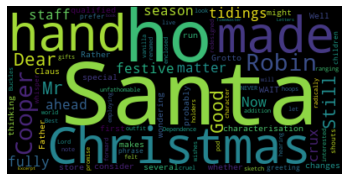

In [59]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [60]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [61]:
word_list = [''.join(word) for word in example_corpus]

In [62]:
novel_as_string = ' '.join(word_list)

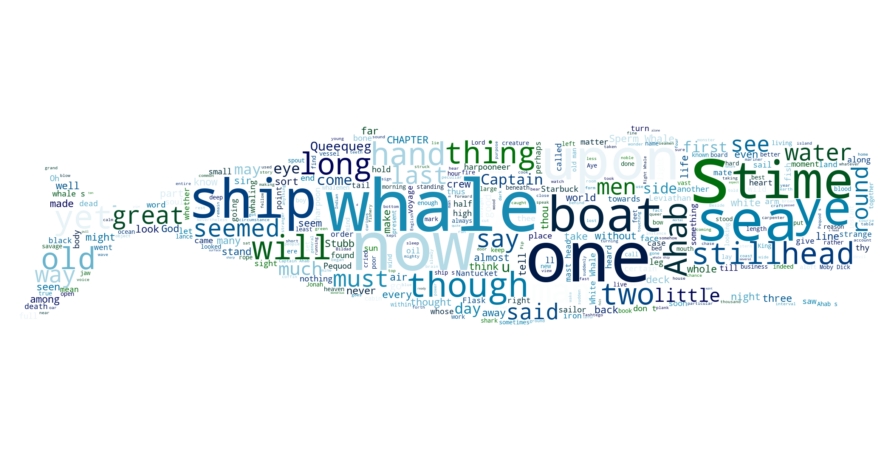

In [63]:
icon = Image.open(WHALE_FILE) #open the image and store it in icon
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255)) #generate a new image with RGB mde, of the size of the icon and background color = white
image_mask.paste(icon, box=icon) #superimpose whale mask on the blank image we created above
rgb_array = np.array(image_mask) #convert the image to array

word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=400,colormap='ocean')
word_cloud.generate(novel_as_string)
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [64]:
rgb_array.shape #whale image is 1024 pixel long, 2048 pixel wide and has 3 color channels

(1024, 2048, 3)

In [65]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

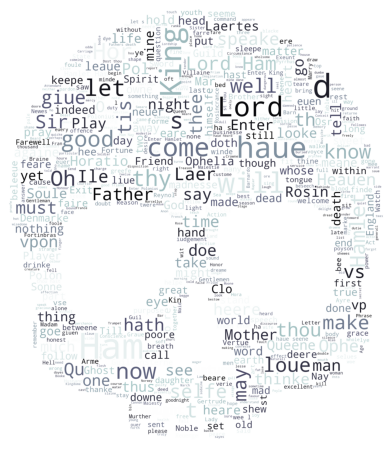

In [66]:
skull_icon = Image.open(SKULL_FILE)
skull_mask = Image.new(mode='RGB',size=skull_icon.size, color=(255,255,255))
skull_mask.paste(skull_icon,box=skull_icon)
hamlet_array = np.array(skull_mask)

hamlet_cloud = WordCloud(mask=hamlet_array, background_color='white',max_words=600,colormap='bone').generate(hamlet_as_string)
plt.figure(figsize=(16,8))
plt.imshow(hamlet_cloud)
plt.axis('off')
plt.show()

In [67]:
flat_list_ham = [item for word in nested_list_ham for item in word]
flat_list_spam = [item for word in nested_list_spam for item in word]

ham_as_string = ' '.join(flat_list_ham)
spam_as_string = ' '.join(flat_list_spam)

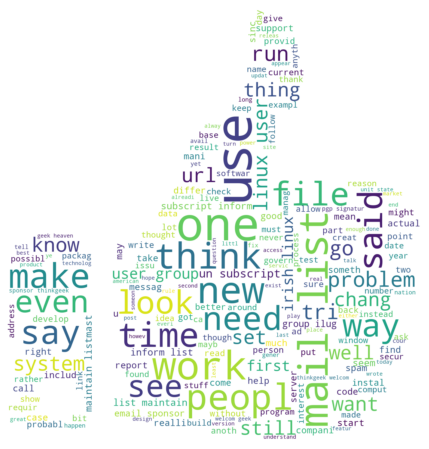

In [68]:
ham_icon = Image.open(HAM_ICON)
ham_mask = Image.new(mode='RGB',size=ham_icon.size, color=(255,255,255))
ham_mask.paste(ham_icon,box=ham_icon)
ham_array = np.array(ham_mask)

ham_cloud = WordCloud(mask=ham_array, background_color='white',max_words=200).generate(ham_as_string)
plt.figure(figsize=(16,8))
plt.imshow(ham_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

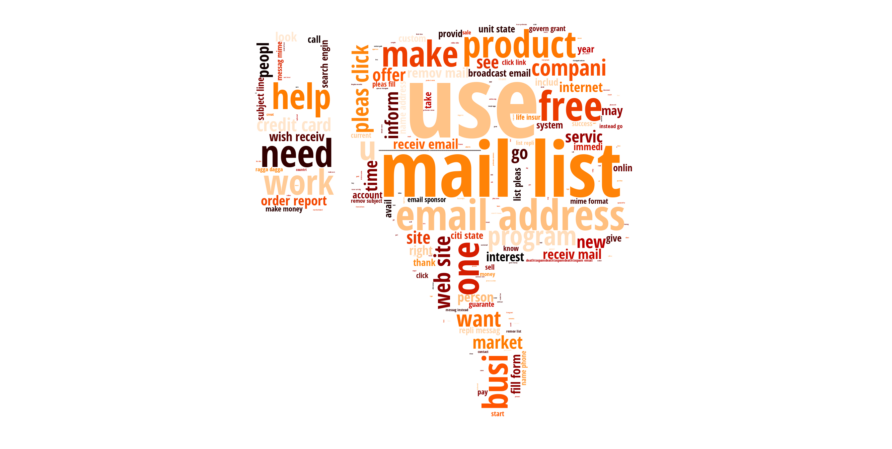

In [69]:
spam_icon = Image.open(SPAM_ICON)
spam_mask = Image.new(mode='RGB',size=spam_icon.size, color=(255,255,255))
spam_mask.paste(spam_icon,box=spam_icon)
spam_array = np.array(spam_mask)

spam_cloud = WordCloud(mask=spam_array, background_color='white',max_words=200,colormap='gist_heat',font_path=CUSTOM_FONT_FILE,max_font_size=300).generate(spam_as_string)
plt.figure(figsize=(16,8))
plt.imshow(spam_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Generating vocabulary for our classifier

In [70]:
stemmed_nested_list = data['MESSAGE'].apply(clean_message_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\jain_\AppData\Local\Programs\Python\Python38\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [71]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print(f'Number of unique words are {unique_words.shape[0]}')

Number of unique words are 27334


In [72]:
unique_words.head()

http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [73]:
frequent_words = unique_words[:VOCAB_SIZE]
print(unique_words[:10])

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


# Create vocab dataframe with word id

In [74]:
vocab = pd.DataFrame({'VOCAB_WORD':frequent_words.index, 'COUNT':frequent_words.values})
vocab.index.name = 'WORD_ID'

In [75]:
vocab.head()

,VOCAB_WORD,COUNT
WORD_ID,,
0,http,10660
1,use,5019
2,list,4851
3,email,4367
4,get,4200


# Save the vocab as csv file

In [76]:
vocab.to_csv(WORD_ID_FILE,index_label=vocab.index.name,header=vocab.columns)

# Checking if the word is in the vocabulary or not

In [77]:
def check_word(word):
    if word in vocab['VOCAB_WORD']:
        return True
    else:
        return False

In [78]:
word_list = ['machine','learning','fun','data','science','app','brewery']
for word in word_list:
    print(check_word(word))

False
False
False
False
False
False
False


In [79]:
data['MESSAGE'].apply(len).argmax()

340

In [80]:
len(data.loc[340]['MESSAGE'])

234358

In [81]:
print(f'The position of longest email {stemmed_nested_list.apply(len).argmax()}')
print(f'Number of words in the longest email {stemmed_nested_list.apply(len).max()}')

The position of longest email 5775
Number of words in the longest email 7671


In [82]:
print('THE LONGEST EMAIL')
print(data.loc[stemmed_nested_list.apply(len).argmax()]['MESSAGE'])

THE LONGEST EMAIL
------------------------ Yahoo! Groups Sponsor ---------------------~-->

4 DVDs Free +s&p Join Now

http://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM

---------------------------------------------------------------------~->



A new version of unison is now available for testing.  It incorporates

several small improvements over 2.9.1, but the main change is a fix to

a bug that had potentially serious safety consequences, but only for

the very small number of users that are in the habit of running more

than one instance of Unison at a time, in parallel.  These users are

strongly encouraged to upgrade.  Others can wait if they wish.



The release includes pre-built executables for Linux and Solaris, but

not Windows.  (We are looking for a Unison-Windows maintainer -- at

the moment, none of the active developers are regularly using Unison

on Windows, and we do not have a machine that is configured properly

for building executables for export.)



Grab i

# Create features and sparse matrix

### Creating a dataframe with one word per column

In [83]:
type(stemmed_nested_list.to_list())

list

In [84]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.to_list())

In [85]:
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [86]:
word_columns_df.shape #5796 is the number of emails that we have and 7671 is the number of words in the longest email

(5796, 7671)

# Splitting the data in train and test set

In [87]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data['CATEGORY'],test_size=0.3,random_state=42)

In [88]:
print(f'Number of training examples {X_train.shape[0]}')
print(f'Number of training examples {X_test.shape[0]}')

Number of training examples 4057
Number of training examples 1739


In [89]:
X_train.index.name =X_test.index.name= 'DOC_ID'

In [90]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [91]:
y_test.head()

4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

# Create a sparse matrix for the training data

In [92]:
word_index = pd.Index(vocab['VOCAB_WORD'])
word_index.get_loc('thu')

393

In [93]:
def make_sparse_matrix(df,indexed_words,labels):
   """
   Returns sparse matrix as dataframe
   Inputs:
   df - dataframe with words in the columns with a document id as index (X_train or X_test)
   indexed_words- index of words ordered by word id
   labels- category as series (y_train or y_test)
   """ 
   nr_rows, nr_cols = df.shape
   word_set = set(indexed_words)
   dict_list = []
   for i in range(nr_rows): #iterate through the  rows
       for j in range(nr_cols): #iterate through columns 
         word = df.iat[i,j] #fetch the word
         if word in word_set: #if the word is in the vocabulary
             doc_id = df.index[i] #get the doc id
             word_id = indexed_words.get_loc(word) #get the word id 
             category = labels.at[doc_id] #get the label for that email at that doc id 
             item = {'LABEL':category,'DOC_ID':doc_id, 'OCCURENCE':1,'WORD_ID':word_id} #store all the information in a dict
             dict_list.append(item) #append the item to the dict list

   return pd.DataFrame(dict_list)

In [94]:
# sparse_train_df = make_sparse_matrix(X_train,word_index, y_train)
# sparse_train_df.to_csv('sparse_train.csv')

In [95]:
sparse_train_df = pd.read_csv('sparse_train.csv')

In [96]:
sparse_train_df.head()

,Unnamed: 0,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,0,4844,1,265
1,1,0,4844,1,1237
2,2,0,4844,1,504
3,3,0,4844,1,308
4,4,0,4844,1,254


In [97]:
sparse_train_df.shape

(429243, 5)

In [98]:
sparse_train_df.tail()

,Unnamed: 0,LABEL,DOC_ID,OCCURENCE,WORD_ID
429238,429238,1,860,1,47
429239,429239,1,860,1,1433
429240,429240,1,860,1,26
429241,429241,1,860,1,21
429242,429242,1,860,1,126


# Combine occurances with pandas groupby method

In [99]:
train_group = sparse_train_df.groupby(by=['DOC_ID','WORD_ID','LABEL']).sum()

In [100]:
train_group.head()

Unnamed: 0  OCCURENCE
DOC_ID WORD_ID LABEL                       
0      2       1           82141          1
       3       1          164289          2
       4       1           82102          1
       7       1          246328          3
       11      1           82135          1

In [101]:
vocab.loc[0]['VOCAB_WORD']

'http'

In [102]:
train_group = train_group.reset_index()
train_group.head()

,DOC_ID,WORD_ID,LABEL,Unnamed: 0,OCCURENCE
0,0,2,1,82141,1
1,0,3,1,164289,2
2,0,4,1,82102,1
3,0,7,1,246328,3
4,0,11,1,82135,1


In [103]:
train_group.tail()

,DOC_ID,WORD_ID,LABEL,Unnamed: 0,OCCURENCE
258357,5795,2025,0,18859,1
258358,5795,2036,0,18877,1
258359,5795,2265,0,18878,1
258360,5795,2346,0,18681,1
258361,5795,2378,0,18712,1


In [104]:
train_group.shape

(258362, 5)

# Save training data as txt file

In [105]:
np.savetxt(TRAINING_DATA_FILE,train_group,fmt='%d')

In [106]:
train_group.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'Unnamed: 0', 'OCCURENCE'], dtype='object')

In [107]:
# sparse_test_df = make_sparse_matrix(X_test,word_index, y_test)
# sparse_test_df.to_csv('sparse_test.csv')

In [108]:
sparse_test_df = pd.read_csv('sparse_test.csv')

In [109]:
sparse_test_df.head()

,Unnamed: 0,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,0,4675,1,89
1,1,0,4675,1,298
2,2,0,4675,1,549
3,3,0,4675,1,84
4,4,0,4675,1,469


In [110]:
test_group = sparse_test_df.groupby(by=['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_group.head()

,DOC_ID,WORD_ID,LABEL,Unnamed: 0,OCCURENCE
0,8,2,1,30048,1
1,8,3,1,120139,4
2,8,4,1,59908,2
3,8,5,1,30061,1
4,8,6,1,59855,2


In [111]:
np.savetxt(TESTING_DATA_FILE,test_group, fmt='%d')

# Checking your understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing. 

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out.

In [112]:
train_doc_ids = set(train_group.DOC_ID)
test_doc_ids = set(test_group.DOC_ID)

In [113]:
not_included_train = set(X_train.index.values)-train_doc_ids
not_included_test = set(X_test.index.values)-test_doc_ids

In [114]:
print(not_included_train)

{138, 1035, 1164, 402, 1170, 22, 1686, 924, 545, 546, 929, 1313, 38, 939, 940, 302, 1846, 186, 193, 197, 965, 328, 73, 1100, 77, 205, 206, 335, 1360, 338, 1234, 86, 983, 1878, 91, 988, 94, 1248, 875, 878, 369, 114, 766, 127}


In [115]:
print(data['MESSAGE'][138]) #all HTML

<html><head></head><body bgcolor=3Dblack>

<table border=3D0 cellspacing=3D0 cellpadding=3D5 align=3Dcenter><tr><th b=

gcolor=3D"#8FB3C5">

<table border=3D0 cellspacing=3D0 cellpadding=3D5 align=3Dcenter><tr><th b=

gcolor=3D"#000000">

<table border=3D0 cellspacing=3D0 cellpadding=3D0 align=3Dcenter>

<tr>

<th><a href=3D"http://psychicrevenue.com/cgi-bin/refer.cgi?pws01014&site=3D=

pw">

<img src=3D"http://giftedpsychic.com/images/r1c1.jpg" width=3D279 height=3D=

286 border=3D0></a></th>

<th><a href=3D"http://psychicrevenue.com/cgi-bin/refer.cgi?pws01014&site=3D=

pw">

<img src=3D"http://giftedpsychic.com/images/r1c2.gif" width=3D301 height=3D=

286 border=3D0></a></th>

</tr>

<tr>

<th><a href=3D"http://psychicrevenue.com/cgi-bin/refer.cgi?pws01014&site=3D=

pw">

<img src=3D"http://giftedpsychic.com/images/r2c1.jpg" width=3D279 height=3D=

94 border=3D0></a></th>

<th><a href=3D"http://psychicrevenue.com/cgi-bin/refer.cgi?pws01014&site=3D=

pw">

<img src=3D"http://giftedpsy

In [116]:
print(data['MESSAGE'][22]) #public or private key

------=_NextPart_000_00B2_83B03D1E.C6530E24

Content-Type: text/html; charset="iso-8859-1"

Content-Transfer-Encoding: base64





PGh0bWw+PGJvZHk+PGRpdiBpZD0ibWVzc2FnZUJvZHkiPjxkaXY+PGZvbnQg

ZmFjZT0iQXJpYWwiIHNpemU9IjIiPlRoaXMgbWVzc2FnZSBpcyBzZW50IHRv

IG91ciBzdWJzY3JpYmVycyBvbmx5LiBGdXJ0aGVyIGVtYWlscyB0byB5b3Ug

YnkgdGhlIHNlbmRlciB0aGlzIG9uZSB3aWxsIGJlIHN1c3BlbmRlZCBhdCBu

byBjb3N0IHRvIHlvdS4gU2NyZWVuaW5nIG9mIGFkZHJlc3NlcyBoYXMgYmVl

biBkb25lIHRvIHRoZSBiZXN0IG9mIG91ciBhYmlsaXR5LCB1bmZvcnR1bmF0

ZWx5IGl0IGlzIGltcG9zc2libGUgdG8gYmUgMTAwJSBhY2N1cmF0ZSwgc28g

aWYgeW91IGRpZCBub3QgYXNrIGZvciB0aGlzLCBvciB3aXNoIHRvIGJlIGV4

Y2x1ZGVkIG9mIHRoaXMgbGlzdCwgcGxlYXNlIGNsaWNrIDxhIGhyZWY9Im1h

aWx0bzpoZWFsdGgxMDVAbWFpbC5ydT9zdWJqZWN0PXJlbW92ZSIgdGFyZ2V0

PSJuZXdfd2luIj5oZXJlPC9hPjwvZm9udD48L2Rpdj4gIDxwPjxiPjxmb250

IGZhY2U9IkFyaWFsIj48Zm9udCBjb2xvcj0iI2ZmMDAwMCI+VEhJUyBJUyBG

T1IgQURVTFQgTUVOIE9OTFkgISBJRiBZT1UgQVJFIE5PVCBBTiBBRFVMVCwg

REVMRVRFIE5PVyAhDQo8cD4NCjxwIGFsaWduPSJjZW50ZXIiPjxpbWcgc3Jj

P